In [27]:
import numpy as np
import random
import time
import cv2
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras import Model, callbacks
from tensorflow.keras.layers import Dense, Flatten, Reshape, UpSampling2D,BatchNormalization, Dropout, Conv2D, Conv2DTranspose
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [28]:
# load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [29]:
# Enter BUFFER_SIZE so that the sample size is a multiple of BATCH_SIZE
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 100

BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]
print(f'Input data shape: {x_train.shape}')
print(f'Number of labels: {y_train.size}')

Input data shape: (60000, 28, 28)
Number of labels: 60000


In [30]:
# Data normalization
x_train = x_train / 255
x_test = x_test / 255

# We form tensors for training and test samples
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Splitting the training sample into BATCHES
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

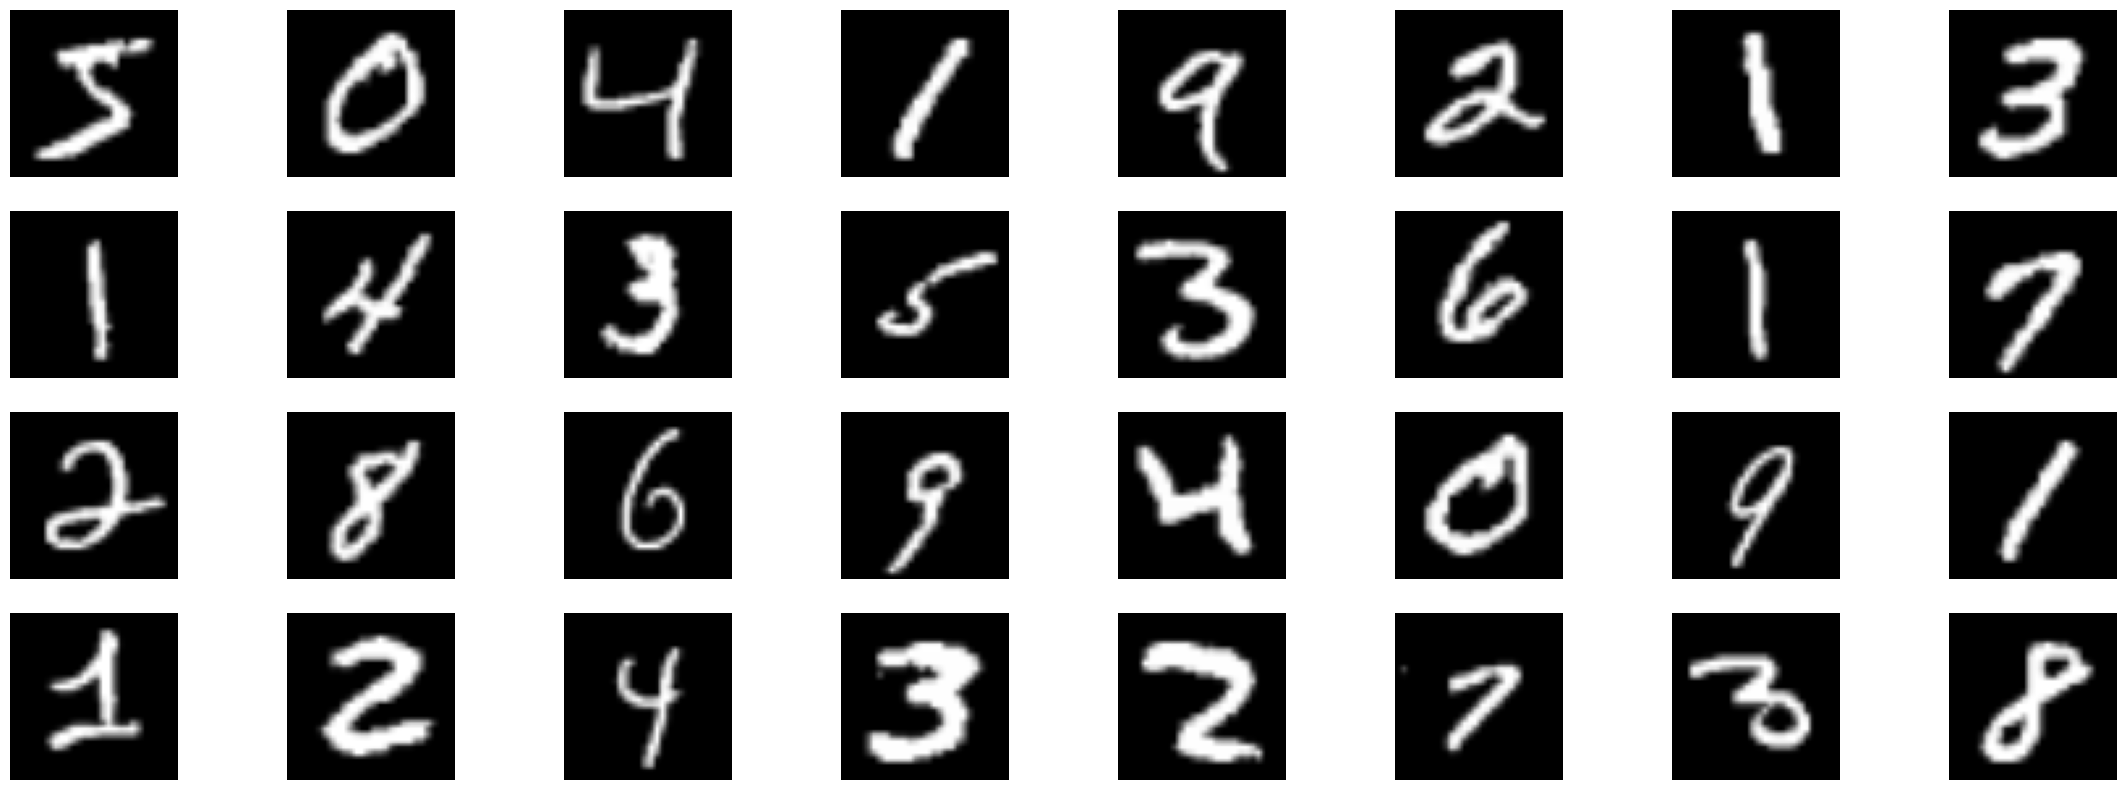

In [31]:
cnt_imgs = 32
counter = 0
IMAGE_SIZE = (64, 64)
plt.figure(figsize=(28, 10))
for img in x_train:
    plt.subplot(4, 8, counter + 1)
    draw_img = cv2.resize(img, IMAGE_SIZE)
    plt.imshow(draw_img, cmap='gray')
    plt.axis('off')
    counter += 1
    if counter == cnt_imgs:
        break

In [32]:
# loss function
cross_entropy = BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    """Function of finding the value of the loss function for the generator (for BATCH)"""
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss


def discriminator_loss(real_output, fake_output):
    """Function of finding the value of the loss function for the discriminator (for BATCH)"""
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [33]:
generator_optimizer = tf.optimizers.Adam(1e-4)
discriminator_optimizer = tf.optimizers.Adam(1e-4)

In [34]:
# We will feed a vector of independent random variables of the hidden dim dimension to the input of the generator
hidden_dim = 2

In [35]:
# First, let's create a generator model
generator = Sequential(name='generator')
generator.add(Dense(7 * 7 * 256, activation='relu', input_shape=(hidden_dim, )))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 256)))  # got a tensor
generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'))

In [21]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12544)             37632     
                                                                 
 batch_normalization_3 (Bat  (None, 12544)             50176     
 chNormalization)                                                
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 7, 7, 128)         819328    
 Transpose)                                                      
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                                
                                                         

In [36]:
# next let's create a discriminator model
discriminator = Sequential(name='discriminator')
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', activation='elu', input_shape=(28, 28, 1)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation='elu'))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(64, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid'))

In [37]:
# compiling neural networks
generator.compile(optimizer=generator_optimizer, loss='binary_crossentropy')
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

In [38]:
# Generator and Discriminator training
@tf.function
def train_step(images) -> (float, float):
    """Function for updating weight coefficients at one training step (for one BATCH)"""
    noise = tf.random.normal([BATCH_SIZE, hidden_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
        return gen_loss, disc_loss

In [39]:
# the learning process for all epochs
def train(dataset,  epochs) -> None:
    """A function to start the learning process for all epochs for the generator and discriminator
    dataset: a set of real images that we store in  generator"""
    history = []
    max_print_label = 10
    th = BUFFER_SIZE // (BATCH_SIZE * max_print_label)

    for epoch in range(1, EPOCHS + 1):
        print(f'{epoch}/{EPOCHS}: ', end='')
        start = time.time()
        n = 0
        gen_loss_epoch = 0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch += K.mean(gen_loss)
            if (n % th == 0):
                print('=', end='')
            n += 1
        print('>', end = ' ')

        history += [gen_loss_epoch / n]
        print(': loss = ' + str(history[-1]))
        print(f'The time of the epoch {epoch} is: {time.time() - start} second')
    return history

In [40]:
def train(dataset, epochs) -> None:
    """A function to start the learning process for all epochs for the generator and discriminator
    dataset: a set of real images that we store in generator"""
    history = []

    for epoch in range(1, epochs + 1):
        print(f'Epoch {epoch}/{epochs}:', end='')
        start = time.time()
        n = 0
        gen_loss_epoch = 0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch += K.mean(gen_loss)
            n += 1

        history.append(gen_loss_epoch / n)
        print(f' Loss: {history[-1]}')
        print(f'The time of the epoch {epoch} is: {time.time() - start} seconds')

    return history


In [41]:
# # Starting the learning process
EPOCHS = 100
gen_history = train(train_dataset, EPOCHS)

Epoch 1/100: Loss: 3.565251350402832
The time of the epoch 1 is: 15.126479625701904 seconds
Epoch 2/100: Loss: 2.4750964641571045
The time of the epoch 2 is: 20.465174913406372 seconds
Epoch 3/100: Loss: 1.8789902925491333
The time of the epoch 3 is: 11.376191139221191 seconds
Epoch 4/100: Loss: 1.7197977304458618
The time of the epoch 4 is: 11.106533765792847 seconds
Epoch 5/100: Loss: 1.7351166009902954
The time of the epoch 5 is: 11.13945484161377 seconds
Epoch 6/100: Loss: 1.9469022750854492
The time of the epoch 6 is: 11.125241994857788 seconds
Epoch 7/100: Loss: 1.9920729398727417
The time of the epoch 7 is: 11.13662838935852 seconds
Epoch 8/100: Loss: 2.090045928955078
The time of the epoch 8 is: 11.123717308044434 seconds
Epoch 9/100: Loss: 2.2308316230773926
The time of the epoch 9 is: 11.125617742538452 seconds
Epoch 10/100: Loss: 2.161574125289917
The time of the epoch 10 is: 11.121022462844849 seconds
Epoch 11/100: Loss: 2.0171751976013184
The time of the epoch 11 is: 11.13

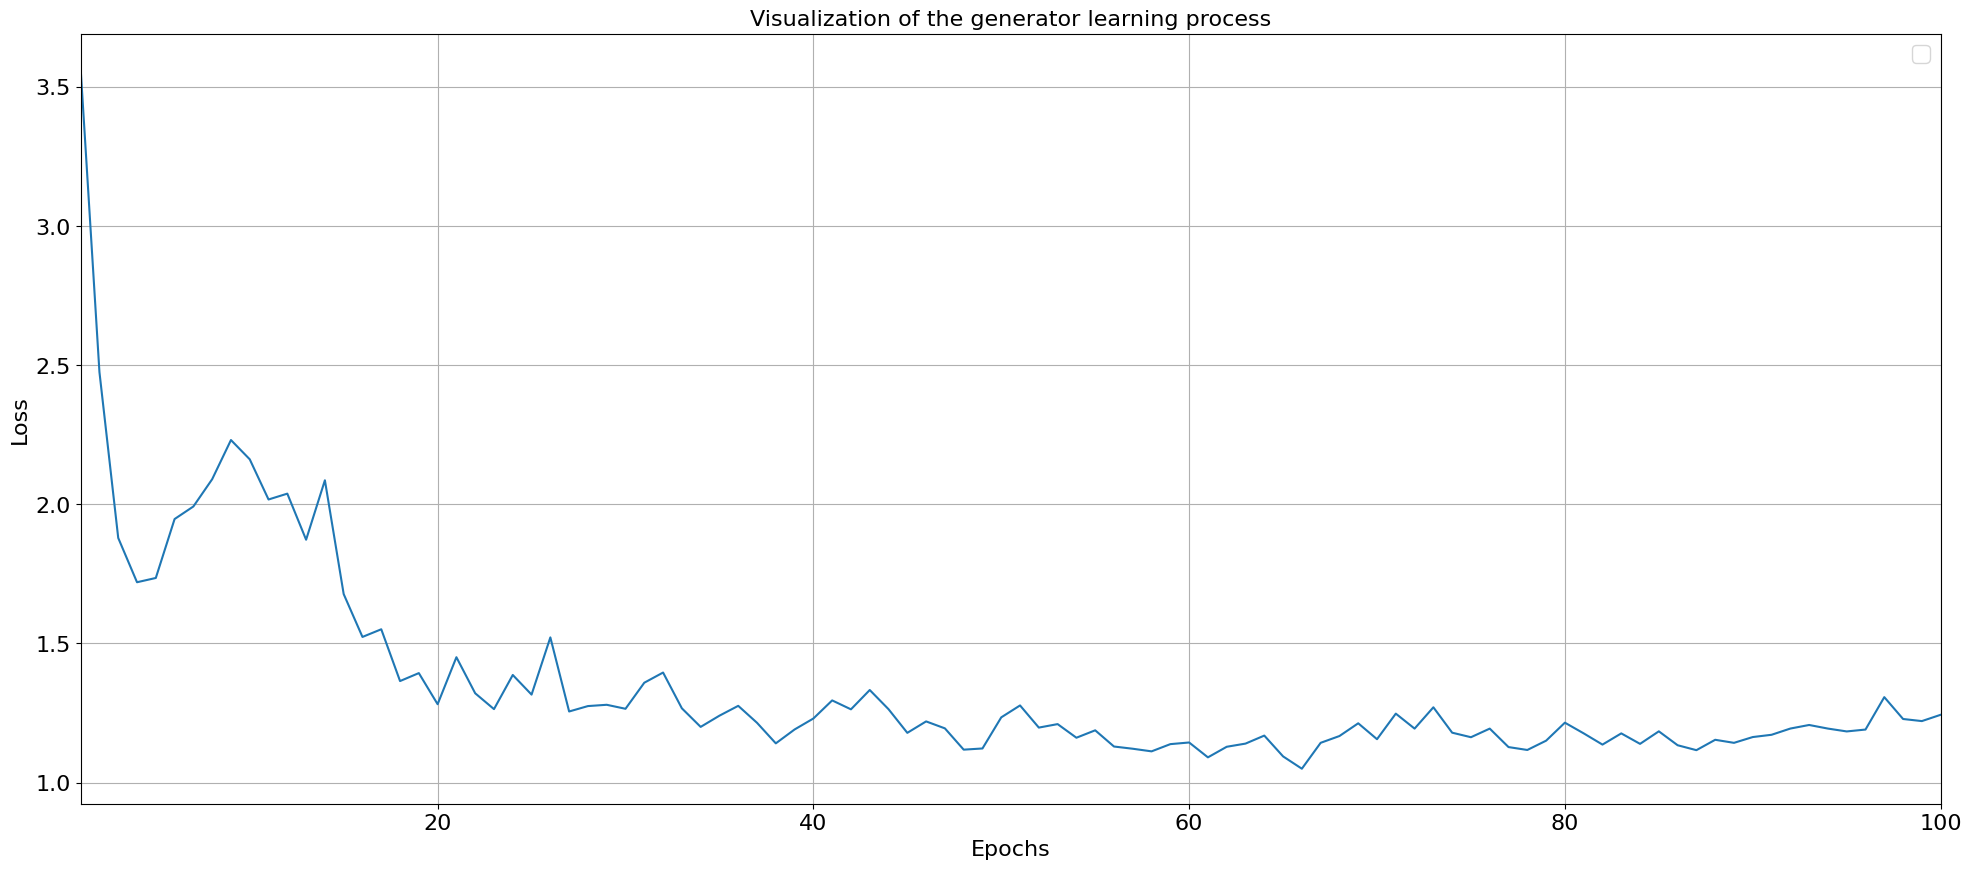

In [42]:
plt.figure(figsize=(24, 10))
plt.title('Visualization of the generator learning process', fontsize=16)
plt.plot(np.arange(1, EPOCHS + 1), gen_history)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(1, EPOCHS)
plt.grid()
plt.legend(fontsize=16)
plt.show()

1/1 [==============================] - 0s 17ms/step


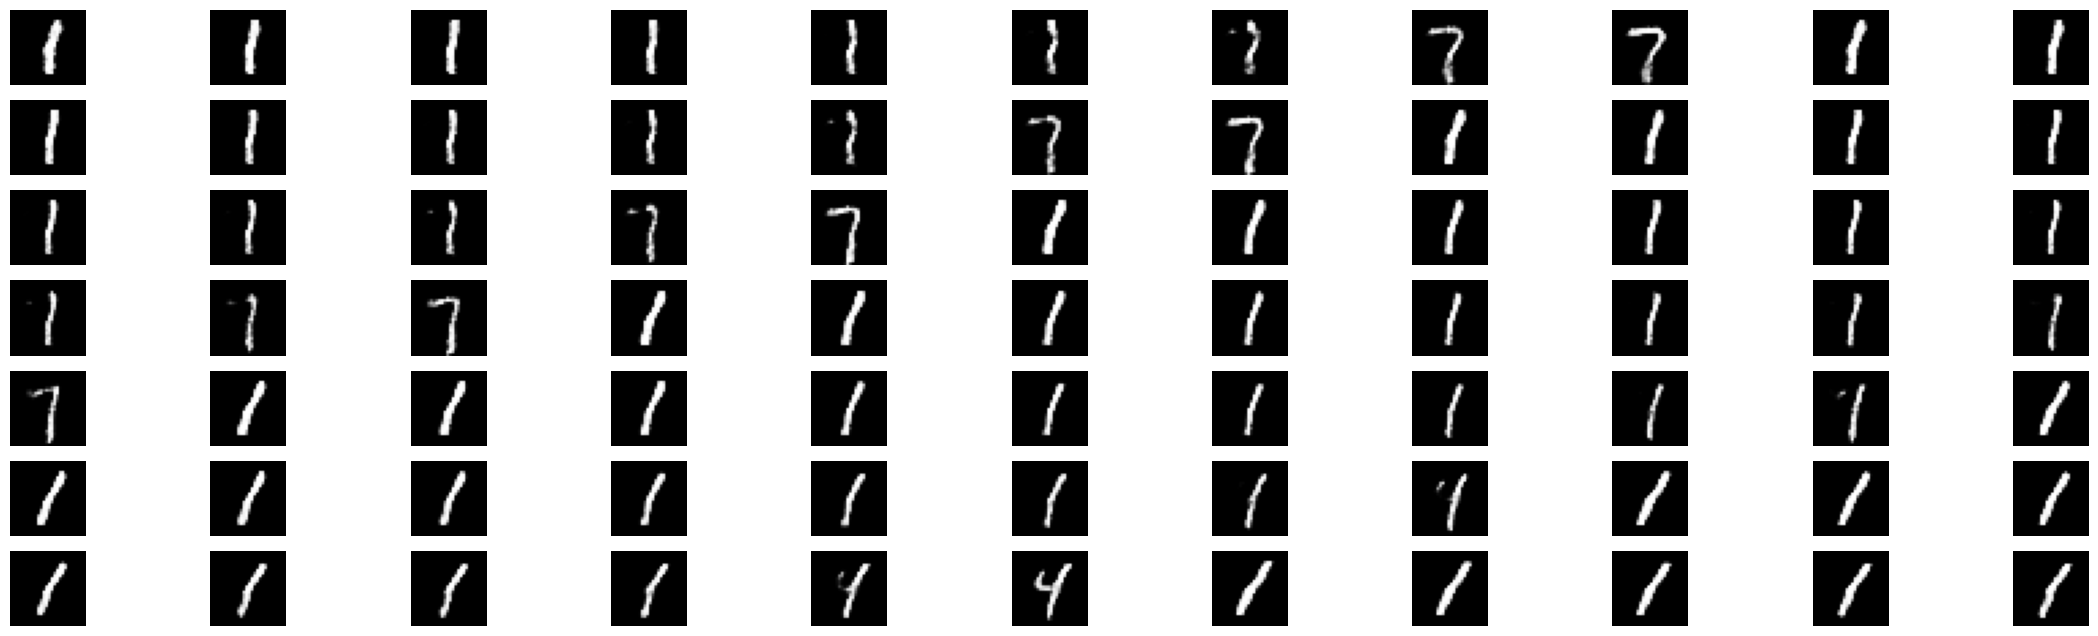

In [43]:
n = 4
total = 2 * n + 1
cnter = 0
plt.figure(figsize=(28, 8))

num = 1
for i in range(-n, n + 1):
    for j in range(-n, n + 1):
        ax = plt.subplot(7, 11, num)
        num += 1
        img = generator.predict(np.expand_dims([0.5 * i / n, 0.5 * j / n], axis=0))
        plt.imshow(img[0, :, :, 0], cmap='gray')
        plt.axis('off')
        if num == 78:
            break
plt.show()

In [ ]:
import tensorflow as tf

# Assuming you have a trained discriminator model and a validation dataset
#discriminator_model = your_trained_discriminator_model
#validation_dataset = your_validation_dataset

# Define a function to evaluate the discriminator's performance
def evaluate_discriminator_performance(discriminator, dataset):
    correct_predictions = 0
    total_samples = 0

    for image_batch, labels in dataset:
        # Apply the discriminator to the batch of images
        predictions = discriminator(image_batch, training=False)

        # Calculate the number of correct predictions
        correct_predictions += tf.reduce_sum(tf.cast(tf.math.round(predictions) == labels, tf.float32))

        # Update the total number of samples
        total_samples += len(labels)

    accuracy = correct_predictions / total_samples
    return accuracy

# Use the function to evaluate the discriminator's performance on the validation dataset
discriminator_accuracy = evaluate_discriminator_performance(discriminator, x_test)

print(f"Discriminator Accuracy on Validation Dataset: {discriminator_accuracy * 100:.2f}%")